<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

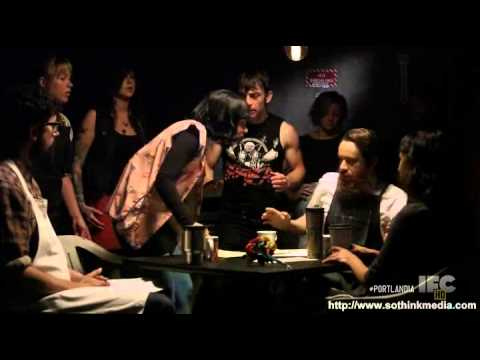

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\thedo\\lambda_u4\\NLP\\module1-text-data'

In [47]:
import pandas as pd

#url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"
url = './data/yelp_coffeeshop_review_data.csv'

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## Cleaning and pre-processing 

In [48]:
def clean_coffee_reviews(df):
    """ Clean and return the dataframe """
    
    # clean the rating column
    df['star_rating'] = df['star_rating'].apply(lambda x: int(x[1]))
    
    # separate date from the review text
    df['review_date'] = df['full_review_text'].apply(lambda x: x.split()[0])
    df['review_date'] = pd.to_datetime(df['review_date'])
    
    # remove date and any leading/trailing whitespace from the review text
    df['full_review_text'] = df['full_review_text'].apply(lambda x: x[x.index(' ', 1):].strip())
    
    return df

In [49]:
shops = clean_coffee_reviews(shops)
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5,2016-11-25
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4,2016-12-02
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4,2016-11-30
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2,2016-11-25
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4,2016-12-03


In [36]:
shops.shape

(7616, 4)

In [27]:
shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [30]:
# number of coffee shops in this data
len(shops['coffee_shop_name'].unique())

79

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

First, let's get the tokens themselves

In [31]:
# set up spacey
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [50]:
# create a column for the review tokens
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['review_tokens'] = tokens

In [51]:
shops['review_tokens'].head()

0    [1, check-in, Love, love, loved, the, atmosphe...
1    [Listed, in, Date, Night:, Austin,, Ambiance, ...
2    [1, check-in, Listed, in, Brunch, Spots, I, lo...
3    [Very, cool, decor!, Good, drinks, Nice, seati...
4    [1, check-in, They, are, located, within, the,...
Name: review_tokens, dtype: object

In [52]:
# Using this from the lecture because it's pretty handy
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [53]:
wc = count(shops['review_tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
2,the,6520,27779,1.0,0.034993,0.034993,0.856092
1,and,6804,25748,2.0,0.032434,0.067427,0.893382
51,a,6181,22085,3.0,0.027820,0.095247,0.811581
50,I,5469,19780,4.0,0.024916,0.120163,0.718093
22,to,5631,16904,5.0,0.021294,0.141457,0.739364


### We will want to remove stop-words.  Let's remove the defaults and see what is left over.

In [54]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['review_tokens'] = tokens

In [56]:
wc = count(shops['review_tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
31,,4343,14990,1.0,0.036535,0.036535,0.570247
9,coffee,4210,8058,2.0,0.019640,0.056175,0.552784
113,place,3029,4264,3.0,0.010393,0.066568,0.397715
130,great,2438,3250,4.0,0.007921,0.074489,0.320116
252,it's,2061,3117,5.0,0.007597,0.082086,0.270614


In [59]:
# interesting, I had thought tokenizer would get rid of these
wc['word'][31]

' '

In [63]:
wc['word'].head(30)

31                
9           coffee
113          place
130          great
252           it's
171           like
167           good
10               1
11        check-in
39            love
348            i'm
96               -
370           i've
793         little
379          don't
162           nice
409           food
636           time
2           pretty
7              got
950         people
538           come
48          austin
467           best
53      definitely
228       friendly
20           latte
41            shop
755        coffee.
1016          iced
Name: word, dtype: object

### That gives me a few words I can remove myself

In [97]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'coffee','coffee.', 'place', "it's", 'i', "i'm", "i've", '1', 
                                            '2', '3', '-', 'check-in', 'check-ins', 'got', 'come', 'austin', 'latte'])

# I actually want to keep "not" and see what happens
STOP_WORDS.remove('not')

In [98]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['review_tokens'] = tokens

In [103]:
wc = count(shops['review_tokens'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
245,not,2712,4037,1.0,0.011002,0.011002,0.356092
121,great,2438,3250,2.0,0.008857,0.019859,0.320116
162,like,2034,2902,3.0,0.007909,0.027768,0.267069
158,good,2084,2779,4.0,0.007573,0.035341,0.273634
33,love,1434,1806,5.0,0.004922,0.040263,0.188288
777,little,1230,1479,6.0,0.004031,0.044293,0.161502
365,don't,1133,1395,7.0,0.003802,0.048095,0.148766
153,nice,1188,1368,8.0,0.003728,0.051823,0.155987
395,food,1092,1363,9.0,0.003715,0.055538,0.143382
621,time,1099,1345,10.0,0.003665,0.059203,0.144301


## Can we visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [100]:
# split between good and bad reviews
good_reviews = shops[shops['star_rating'] >= 4]
wc_good = count(good_reviews['review_tokens'])

bad_reviews = shops[shops['star_rating'] <= 3]
wc_bad = count(bad_reviews['review_tokens'])

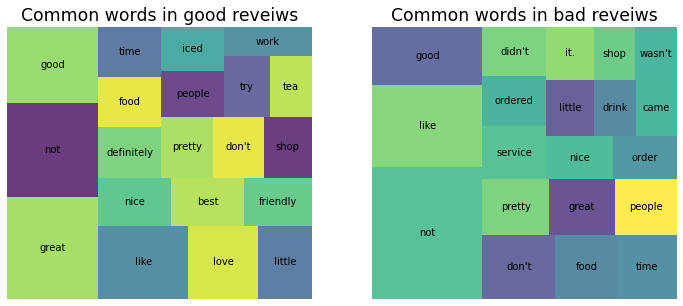

In [101]:
import squarify
import matplotlib.pyplot as plt

# plotting them side by side
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,5)

# words in good reviews
squarify.plot(sizes=wc_good['pct_total'][:20], label=wc_good['word'][:20], alpha=.8, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Common words in good reveiws', size='xx-large')

# words in bad reviews
squarify.plot(sizes=wc_bad['pct_total'][:20], label=wc_bad['word'][:20], alpha=.8, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Common words in bad reveiws', size='xx-large')

plt.show()

In [104]:
# combine the data to analyze differences
wc_combined = wc_good.merge(wc_bad, on='word', suffixes=('_good', '_bad'))
wc_combined = wc_combined[['word', 'pct_total_good', 'pct_total_bad', 'appears_in_pct_good', 'appears_in_pct_bad']]
wc_combined['pct_total_diff'] = wc_combined['pct_total_good'] - wc_combined['pct_total_bad']
wc_combined['appears_in_diff'] = wc_combined['appears_in_pct_good'] - wc_combined['appears_in_pct_bad']
wc_combined.head()

,word,pct_total_good,pct_total_bad,appears_in_pct_good,appears_in_pct_bad,pct_total_diff,appears_in_diff
0,great,0.010197,0.004227,0.354072,0.178862,0.005970,0.175210
1,not,0.009424,0.016458,0.312704,0.536585,-0.007034,-0.223882
2,good,0.007660,0.007275,0.267590,0.298780,0.000384,-0.031191
3,like,0.007266,0.010130,0.242020,0.371274,-0.002864,-0.129254
4,love,0.005636,0.002453,0.205700,0.115854,0.003182,0.089847


In [105]:
# biggest differences in pct_total,
# positive values mean the word is more common in good reviews than bad ones
wc_combined[['word', 'pct_total_diff']].sort_values('pct_total_diff')

,word,pct_total_diff
1,not,-0.007034
3,like,-0.002864
371,asked,-0.001928
59,didn't,-0.001853
13,don't,-0.001832
...,...,...
26,delicious,0.001920
8,friendly,0.001972
7,best,0.002966
4,love,0.003182


In [106]:
# biggest differences in appears_in
wc_combined[['word', 'appears_in_diff']].sort_values('appears_in_diff')

,word,appears_in_diff
1,not,-0.223882
3,like,-0.129254
13,don't,-0.101199
31,service,-0.082855
59,didn't,-0.081514
...,...,...
26,delicious,0.079408
8,friendly,0.079963
4,love,0.089847
7,best,0.111526


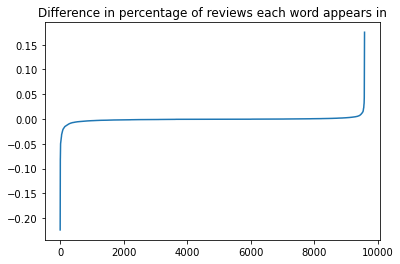

In [109]:
plt.plot(range(len(wc_combined)), wc_combined['appears_in_diff'].sort_values())
plt.title('Difference in percentage of reviews each word appears in')
plt.show()

The above graph isn't so easy to understand right away.  It displays the difference in percentage of good vs bad reviews that each word appears in.  The main takeaway is that the vast majority of the ~9500 words have a value close to 0, which means they are about equally likely to appear in either a good or bad review.  This also means that we can get a much shorter list of words that appear in each type of review.

In [121]:
# Let's get those differentiating words
cutoff_pct = .045

temp = wc_combined[['word', 'appears_in_diff']].sort_values('appears_in_diff')
good_words = temp[temp['appears_in_diff'] >= cutoff_pct]
bad_words = temp[temp['appears_in_diff'] <= -cutoff_pct]

print(f"With a cutoff of {cutoff_pct}, there are {len(good_words)} positive words and {len(bad_words)} negative words")

With a cutoff of 0.045, there are 8 positive words and 23 negative words


In [122]:
good_words.append(bad_words)

,word,appears_in_diff
28,favorite,0.060444
40,perfect,0.061759
9,definitely,0.062132
26,delicious,0.079408
8,friendly,0.079963
4,love,0.089847
7,best,0.111526
0,great,0.175210
1,not,-0.223882
3,like,-0.129254


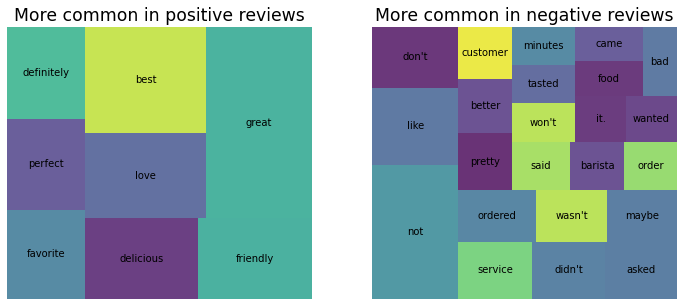

In [124]:
# let's show it in the square plot again
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,5)

# words in good reviews
squarify.plot(sizes=good_words['appears_in_diff'], label=good_words['word'], alpha=.8, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('More common in positive reviews', size='xx-large')

# words in bad reviews
squarify.plot(sizes=bad_words['appears_in_diff'], label=bad_words['word'], alpha=.8, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('More common in negative reviews', size='xx-large')

plt.show()

And there we have it.  A graphical representation of which words are more likely to appear in each kind of review.

Some interesting notes:

- Since I used the "appears_in" column, this visualization is based off the percentage of reviews each word appeared in at least once.  Duplicate words in each review are not counted this way.
- There was more variation in the negative words than positive ones.  Perhaps this is due to how many more positive reviews there are than negative?  The fewer reviews there are in total, the more an outlier word would show up.
- "Not" is a default stop-word, but it actually had the biggest difference in appearance rate of any of the words.  Using this method of comparing appearance rates and not counting duplicates, it might not actually be necessary to remove stop-words at all.

### Lemmatization

I did not apply lemmatization at all to the above graphic, so let's do that here

In [134]:
# A function for getting lemma tokens from review text
def get_lemmas(text):

    lemmas = []    
    doc = nlp(text)
    
    for token in doc: 
        if (token.text.lower() not in STOP_WORDS) and (token.is_punct == False) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_.lower())
    
    return lemmas

In [135]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [136]:
shops['lemmas'].head()

0    [check, love, love, love, atmosphere, corner, ...
1    [list, date, night, ambiance, beautiful, love,...
2    [check, list, brunch, spots, love, eclectic, h...
3    [cool, decor, good, drink, nice, seating, over...
4    [check, locate, northcross, mall, shopping, ce...
Name: lemmas, dtype: object

In [145]:
# same analysis as before

# Get lemma statistics split by good and bad reviews
lemma_good = count(shops[shops['star_rating'] >= 4]['lemmas'])
lemma_bad = count(shops[shops['star_rating'] <= 3]['lemmas'])

# combine the data to analyze differences
lemma_combined = lemma_good.merge(lemma_bad, on='word', suffixes=('_good', '_bad'))
lemma_combined = lemma_combined[['word', 'pct_total_good', 'pct_total_bad', 'appears_in_pct_good', 'appears_in_pct_bad']]
lemma_combined['pct_total_diff'] = lemma_combined['pct_total_good'] - lemma_combined['pct_total_bad']
lemma_combined['appears_in_diff'] = lemma_combined['appears_in_pct_good'] - lemma_combined['appears_in_pct_bad']
lemma_combined.sort_values('pct_total_diff')

,word,pct_total_good,pct_total_bad,appears_in_pct_good,appears_in_pct_bad,pct_total_diff,appears_in_diff
2,not,0.011102,0.019696,0.333876,0.552846,-0.008594,-0.218969
14,order,0.005168,0.010053,0.165472,0.291328,-0.004885,-0.125856
4,like,0.009182,0.012517,0.273127,0.403794,-0.003335,-0.130667
140,ask,0.001305,0.004305,0.050651,0.149051,-0.003000,-0.098400
84,$,0.002086,0.005047,0.064169,0.147696,-0.002960,-0.083527
...,...,...,...,...,...,...,...
0,good,0.016440,0.013299,0.477362,0.439024,0.003142,0.038337
15,delicious,0.004965,0.001192,0.192182,0.057588,0.003772,0.134594
3,check,0.011098,0.006967,0.437459,0.330623,0.004131,0.106836
5,love,0.008043,0.003351,0.262215,0.141599,0.004692,0.120616


So lemmatization took us from 9582 unique tokens down to 5167, not bad.

In [153]:
# Get the most different words
cutoff_pct = .05

temp = lemma_combined[['word', 'appears_in_diff']].sort_values('appears_in_diff', ascending=False)
good_lemmas = temp[temp['appears_in_diff'] >= cutoff_pct]
bad_lemmas = temp[temp['appears_in_diff'] <= -cutoff_pct]

print(f"With a cutoff of {cutoff_pct}, there are {len(good_lemmas)} positive words and {len(bad_lemmas)} negative words")

With a cutoff of 0.05, there are 12 positive words and 30 negative words


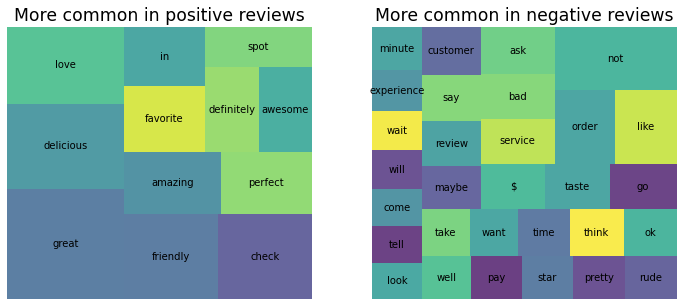

In [154]:
# Show the visualization after lemmitization
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,5)

# words in good reviews
squarify.plot(sizes=good_lemmas['appears_in_diff'], label=good_lemmas['word'], alpha=.8, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('More common in positive reviews', size='xx-large')

# words in bad reviews
squarify.plot(sizes=bad_lemmas['appears_in_diff'], label=bad_lemmas['word'], alpha=.8, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('More common in negative reviews', size='xx-large')

plt.show()

In [155]:
good_lemmas.head()

,word,appears_in_diff
1,great,0.173185
15,delicious,0.134594
5,love,0.120616
10,friendly,0.108296
3,check,0.106836


In [157]:
bad_lemmas.tail()

,word,appears_in_diff
202,bad,-0.094003
140,ask,-0.098400
14,order,-0.125856
4,like,-0.130667
2,not,-0.218969


So lemmitization cut the number of unique tokens almost in half, and got us a bit more variation in the most differentiating words.  Mostly the same words on each side of the graph, but it's still interesting.  I hadn't meant to include the $, but it makes sense that negative reviews might complain about price while positive ones might not mention it.

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 



### Compare my results back to the original ratings

I threw a lot of numbers out there, but I wonder if I can compare it back to the star rating?

To find out, I'm going to sum up the total of the 'appears_in_diff' value for each token in a review, and save that as a new column that I can analyze.  It will be interesting if I can get a single value that relates back to the star rating.

In [ ]:
# using these values
lemma_mappings = lemma_combined[['word', 'appears_in_diff']].set_index('word').to_dict()['appears_in_diff']
lemma_mappings

In [177]:
# Define a function that maps lemmas to those values then sums them
def sum_lemmas(lemmas):
    return pd.Series(lemmas).map(lemma_mappings).sum()

In [ ]:
# Create a new column and apply the function to it
shops['lemma_value'] = shops['lemmas'].apply(sum_lemmas)

# Also get the average value to normalize between longer and shorter reviews
shops['lemma_avg'] = [0.0] * len(shops)
for i in range(len(shops)):
    shops.at[i, 'lemma_avg'] = shops.at[i, 'lemma_value'] / len(shops.at[i, 'lemmas'])

In [186]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,review_tokens,lemmas,lemma_value,lemma_avg
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5,2016-11-25,"[love, love, loved, atmosphere!, corner, shop,...","[check, love, love, love, atmosphere, corner, ...",-0.021065,-0.000527
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4,2016-12-02,"[listed, date, night:, austin,, ambiance, beau...","[list, date, night, ambiance, beautiful, love,...",-0.218795,-0.008415
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4,2016-11-30,"[listed, brunch, spots, loved, eclectic, homey...","[check, list, brunch, spots, love, eclectic, h...",0.304124,0.003168
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2,2016-11-25,"[cool, decor!, good, drinks, nice, seating, ho...","[cool, decor, good, drink, nice, seating, over...",-0.552242,-0.015778
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4,2016-12-03,"[located, northcross, mall, shopping, center, ...","[check, locate, northcross, mall, shopping, ce...",0.117634,0.001928


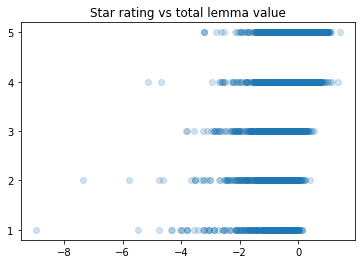

In [196]:
# Now we can plot those and visually see how good of a representation it is
plt.scatter(shops['lemma_value'], shops['star_rating'], alpha=.2)
plt.title('Star rating vs total lemma value')
plt.yticks(range(1,6), range(1,6))
plt.show()

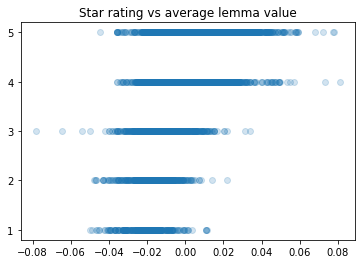

In [197]:
plt.scatter(shops['lemma_avg'], shops['star_rating'], alpha=.2)
plt.title('Star rating vs average lemma value')
plt.yticks(range(1,6), range(1,6))
plt.show()

Ok, so that single value doesn't predict very well what the star rating is on it's own.  That's ok, just means that any predictive models would need to use more than that one feature.